## <p style="text-align: center">DT2119 Lab1: Feature Extraction</p>

The following packages and files will be used to accomplish the different tasks.

In [2]:
from lab1_tools import lifter, trfbank, tidigit2labels
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist as euclidean
from scipy import signal
from scipy.fftpack import fft
from scipy.fftpack.realtransforms import dct
import sklearn.mixture as mix
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy

The following are all the implemented functions which will be used
to accomplish the different tasks.

In [3]:
def mspec(samples, winlen=400, winshift=200, preempcoeff=0.97, nfft=512, samplingrate=20000):
    """Computes Mel Filterbank features.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        samplingrate: sampling rate of the original signal

    Returns:
        N x nfilters array with mel filterbank features (see trfbank for nfilters)
    """
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    return logMelSpectrum(spec, samplingrate)

def mfcc(samples, winlen=400, winshift=200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22):
    """Computes Mel Frequency Cepstrum Coefficients.

    Args:
        samples: array of speech samples with shape (N,)
        winlen: lenght of the analysis window
        winshift: number of samples to shift the analysis window at every time step
        preempcoeff: pre-emphasis coefficient
        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)
        nceps: number of cepstrum coefficients to compute
        samplingrate: sampling rate of the original signal
        liftercoeff: liftering coefficient used to equalise scale of MFCCs

    Returns:
        N x nceps array with lifetered MFCC coefficients
    """
    mspecs = mspec(samples, winlen, winshift, preempcoeff, nfft, samplingrate)
    ceps = cepstrum(mspecs, nceps)
    return lifter(ceps, liftercoeff)


def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows.

    Args:
        samples: list of received samples.
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """

    enframed_samples = np.zeros((1, winlen))  # Define the resulting matrix of samples
    start = 0  # Define starting pointer of the sample array
    end = min(winlen, len(samples))  # Define ending pointer of the sample array
    enframed_samples[0, start:end] = samples[start:end]  # Enframe the first window of samples
    overlap_samples = enframed_samples[0, winlen - winshift:winlen]  # Define the first overlap of samples
    start = end  # Update starting pointer
    end += min(winlen - winshift, len(samples) - end)  # Update ending pointer
    while end - start + len(overlap_samples) == enframed_samples.shape[1]:  # While the sample fills the window
        enframed_samples = np.vstack((enframed_samples, np.zeros((1, winlen))))  # Generate new window
        enframed_samples[-1, 0:len(overlap_samples)] = overlap_samples
        enframed_samples[-1, len(overlap_samples):end - start + len(overlap_samples)] = samples[start:end]
        overlap_samples = enframed_samples[-1, winlen - winshift:winlen]
        start = end
        end += min(winlen - winshift, len(samples) - end)

    return enframed_samples

    
def preemp(samples, p=0.97):
    """
    Pre-emphasis filter.

    Args:
        samples: array of speech frames [N x M] where N is the number of frames and
               M the samples per frame
        p: preemhasis factor (defaults to the value specified in the exercise)

    Output:
        output: array of pre-emphasised speech samples
    Note (you can use the function lfilter from scipy.signal)
    """

    samples = signal.lfilter([1, -p], [1], samples)  # Apply filter to samples enframed matrix

    return samples


def windowing(samples):
    """
    Applies hamming window to the input frames.

    Args:
        samples: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
    Output:
        array of windoed speech samples [N x M]
    Note (you can use the function hamming from scipy.signal, include the sym=0 option
    if you want to get the same results as in the example)
    """

    hamming_window = signal.hamming(samples.shape[1], sym=False)  # Obtain hamming window according to window shape

    return hamming_window * samples  # Return samples once window is applied


def powerSpectrum(sample, nfft):
    """
    Calculates the power spectrum of the input signal, that is the square of the modulus of the FFT

    Args:
        sample: array of speech samples [N x M] where N is the number of frames and
               M the samples per frame
        nfft: length of the FFT
    Output:
        array of power spectra [N x nfft]
    Note: you can use the function fft from scipy.fftpack
    """

    f = fft(sample, nfft)
    power_spectrum = np.abs(pow(f, 2))

    return power_spectrum


def logMelSpectrum(sample, samplingrate):
    """
    Calculates the log output of a Mel filterbank when the input is the power spectrum

    Args:
        sample: array of power spectrum coefficients [N x nfft] where N is the number of frames and
               nfft the length of each spectrum
        samplingrate: sampling rate of the original signal (used to calculate the filterbank shapes)
    Output:
        array of Mel filterbank log outputs [N x nmelfilters] where nmelfilters is the number
        of filters in the filterbank
    Note: use the trfbank function provided in lab1_tools.py to calculate the filterbank shapes and
          nmelfilters
    """

    trf = trfbank(samplingrate, sample.shape[1])
    _mspec = np.log(sample @ trf.T)

    return _mspec


def cepstrum(sample, nceps):
    """
    Calulates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform

    Args:
        sample: array of log outputs of Mel scale filterbank [N x nmelfilters] where N is the
               number of frames and nmelfilters the length of the filterbank
        nceps: number of output cepstral coefficients
    Output:
        array of Cepstral coefficients [N x nceps]
    Note: you can use the function dct from scipy.fftpack.realtransforms
    """

    cepstral_coeff = dct(sample)[:, :nceps]
    
    return cepstral_coeff


def dtw(x, y, dist=euclidean):
    """Dynamic Time Warping.

    Args:
        x: arrays of size NxD and MxD respectively, where D is the dimensionality
           and N, M are the respective lenghts of the sequences
        y: arrays of size NxD and MxD respectively, where D is the dimensionality
           and N, M are the respective lenghts of the sequences
        dist: distance function (can be used in the code as dist(x[i], y[j]))

    Outputs:
        gl_distance: global distance between the sequences (scalar) normalized to len(x)+len(y)
        lc_dist: local distance between frames from x and y (NxM matrix)
        acc_dist: accumulated distance between frames of x and y (NxM matrix)
        path: best path thtough acc_dist

    Note that you only need to define the first output for this exercise.
    """
    lc_dist = dist(x, y)  # Calculation of the local distances
    acc_dist = float('inf') * np.ones(lc_dist.shape)  # Initialization of acc. distances
    acc_dist[0, 0] = lc_dist[0, 0]  # First distance --> nothing accumulated
    for i in range(1, acc_dist.shape[1]):
        acc_dist[0, i] = acc_dist[0, i - 1] + lc_dist[0, i]  # 1st row
    for i in range(1, acc_dist.shape[0]):
        acc_dist[i, 0] = acc_dist[i - 1, 0] + lc_dist[i, 0]  # 1st col

    for i in range(1, acc_dist.shape[0]):
        for j in range(1, acc_dist.shape[1]):
            acc_dist[i, j] = lc_dist[i, j] + min(acc_dist[i - 1, j], acc_dist[i, j - 1], acc_dist[i - 1, j - 1])

    gl_distance = acc_dist[-1, -1] / (x.shape[0] + y.shape[0])

    return gl_distance, lc_dist, acc_dist


def mspec_only(samples, winlen=400, winshift=200, preempcoeff=0.97, nfft=512, nceps=13, samplingrate=20000, liftercoeff=22):
    frames = enframe(samples, winlen, winshift)
    preemph = preemp(frames, preempcoeff)
    windowed = windowing(preemph)
    spec = powerSpectrum(windowed, nfft)
    mspec = logMelSpectrum(spec, samplingrate)

    return mspec


def plotPosterior(posterior, component, ut):
    sum_posterior = np.sum(posterior, axis=0).reshape(1,-1)
    sum_posterior /= np.sum(posterior)
    print("Posterior Probability " + str(sum_posterior))
    plt.figure()
    plt.pcolormesh(posterior)
    plt.xlabel("Samples")
    plt.ylabel("Components")
    plt.title("Posterior probability GMM components " + str(component) + " utterance #" + str(ut))
    plt.colorbar()
    plt.show()
    

### Here starts the program main code:
Load of the data samples

In [7]:
data = np.load('lab1_example.npz', allow_pickle=True)['example'].item() 
samples = data['samples']

Performing Mel Frequency Cepstrum Coefficients step-by-step:

In [8]:
winlen = int(data['samplingrate'] * 0.02)
winshift = int(data['samplingrate'] * 0.01)

Enframe samples:

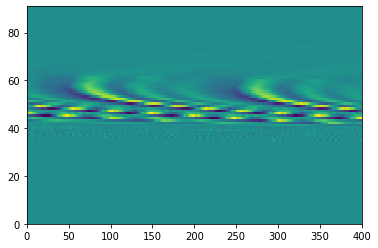

In [9]:
enframed = enframe(samples, winlen, winshift)
plt.pcolormesh(enframed)
plt.show()

Pre-emphasis of data:

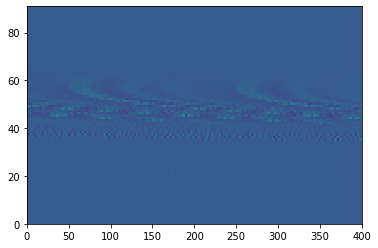

In [10]:
pre_emphasized = preemp(enframed, p=0.97)
plt.pcolormesh(pre_emphasized)
plt.show()

Applying hamming window:

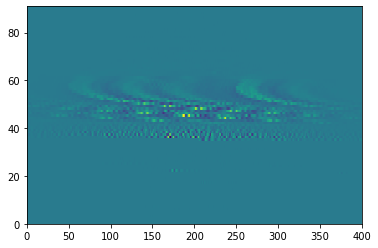

In [11]:
windowed = windowing(pre_emphasized)
plt.pcolormesh(windowed)
plt.show()

Calculating the Fast Fourier Transform:

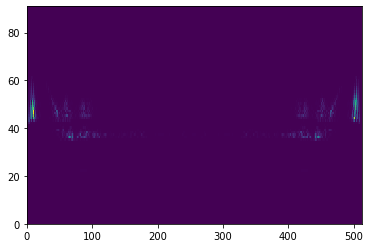

In [12]:
_fft = powerSpectrum(windowed, 512)
plt.pcolormesh(_fft)
plt.show()

 
Applying Mel filterbank log spectrum

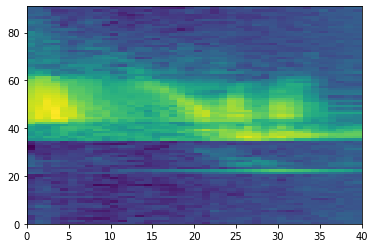

In [13]:
_mspec = logMelSpectrum(_fft, data['samplingrate'])
plt.pcolormesh(_mspec)
plt.show()

Applying cosine transform and liftering:

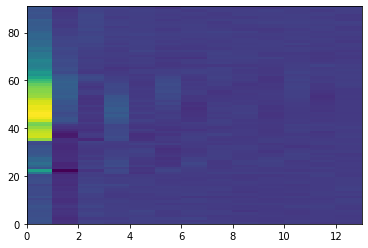

In [14]:
ceps = cepstrum(_mspec, 13)
plt.pcolormesh(ceps)
plt.show()

Applying the feature correlation:

In [16]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']
mfcc_utterances = list()
mspec_utterances = list()

for audio_sample in data:
    mfcc_sample = mfcc(audio_sample["samples"])
    mfcc_utterances.append(mfcc_sample)
    mspec_sample = mspec_only(audio_sample["samples"])
    mspec_utterances.append(mspec_sample)

mfcc_data = np.vstack(mfcc_utterances)
mspec_data = np.vstack(mspec_utterances)

mfcc_r = np.corrcoef(mfcc_data, rowvar=False)
mspec_r = np.corrcoef(mspec_data, rowvar=False)

Exploring speech segments with clustering:

Posterior Probability [[0.38377484 0.32683583 0.07715408 0.21223525]]
Posterior Probability [[0.28254247 0.42389735 0.08642952 0.20713065]]
Posterior Probability [[0.49158099 0.37381464 0.11242323 0.02218115]]
Posterior Probability [[0.37123492 0.38742355 0.13495273 0.1063888 ]]
Posterior Probability [[0.26304782 0.12449911 0.02221965 0.06067543 0.13110861 0.22427542
  0.03315074 0.14102323]]
Posterior Probability [[0.36194915 0.08681851 0.01528342 0.06188823 0.16790891 0.17265606
  0.03805937 0.09543633]]
Posterior Probability [[0.13047535 0.05399594 0.16869234 0.11440176 0.07632659 0.24862522
  0.18100169 0.02648111]]
Posterior Probability [[0.13371876 0.0961571  0.18710412 0.13258437 0.08100689 0.21643705
  0.14353007 0.00946164]]
Posterior Probability [[6.74574292e-11 2.25202736e-01 3.67415012e-09 5.87083280e-02
  1.39471764e-01 1.87922467e-01 3.17057952e-02 2.07403091e-01
  1.09328094e-06 1.17595795e-01 2.21312724e-35 9.72337318e-03
  2.22636667e-02 1.88593707e-06 1.22992715e-19 2

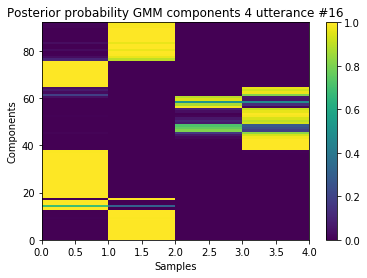

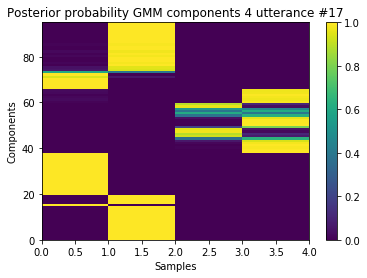

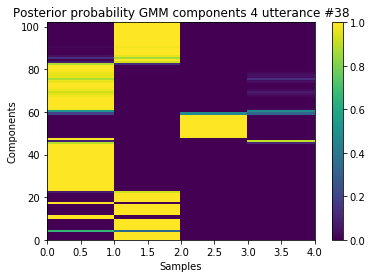

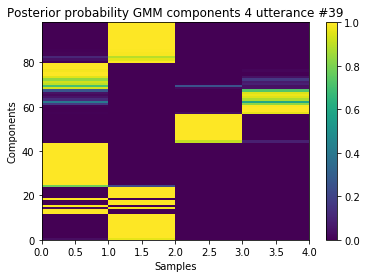

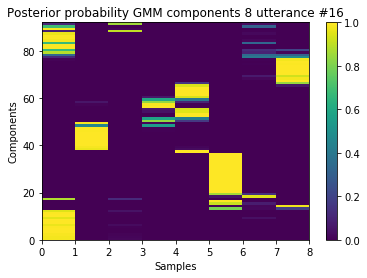

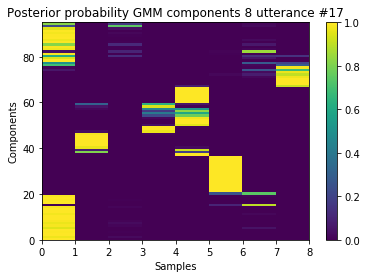

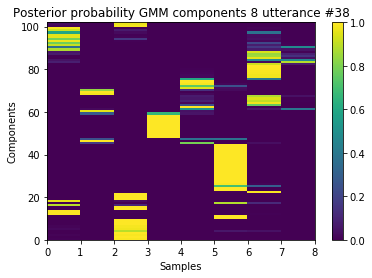

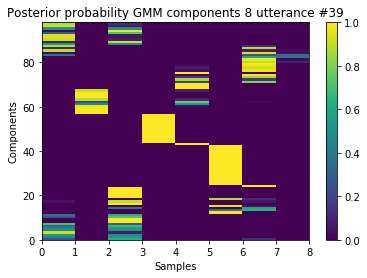

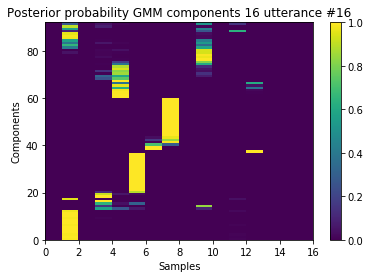

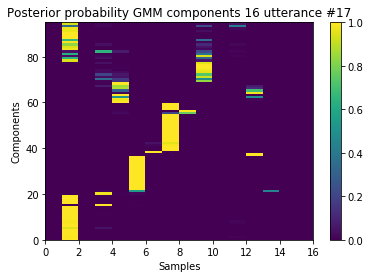

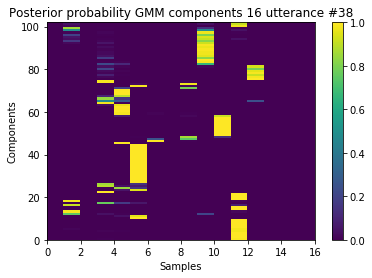

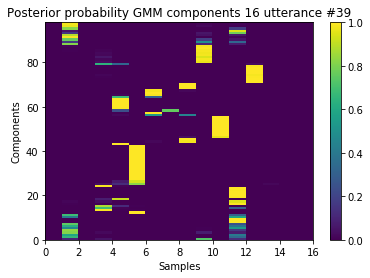

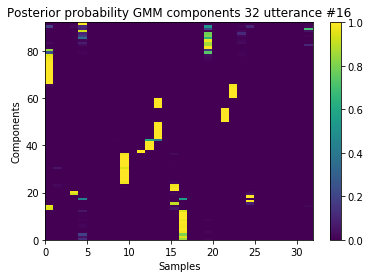

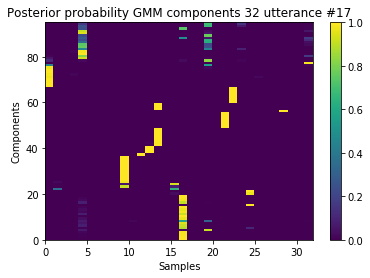

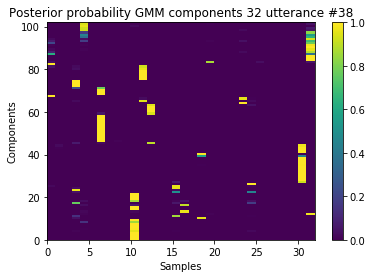

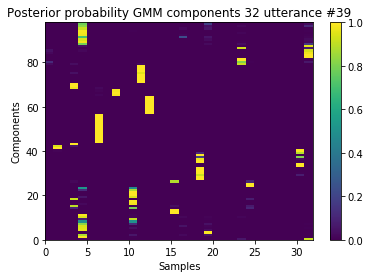

In [17]:
components = [4, 8, 16, 32]

for component in components:
    g = mix.GaussianMixture(n_components=component)
    g.fit(mfcc_data)
    posterior = g.predict_proba(mfcc_utterances[16])
    plotPosterior(posterior, component, 16)
    posterior = g.predict_proba(mfcc_utterances[17])
    plotPosterior(posterior, component, 17)
    posterior = g.predict_proba(mfcc_utterances[38])
    plotPosterior(posterior, component, 38)
    posterior = g.predict_proba(mfcc_utterances[39])
    plotPosterior(posterior, component, 39)
    

Comparing utterances:

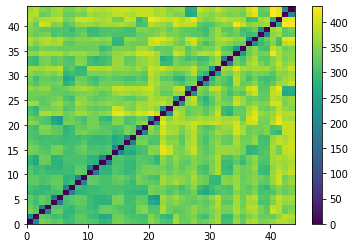

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # This is added back by InteractiveShellApp.init_path()


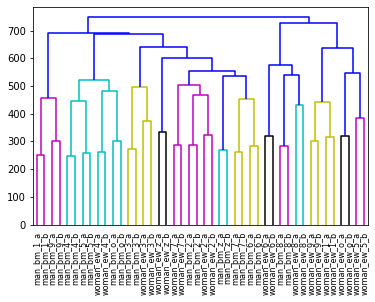

In [20]:
global_distances = np.zeros((len(mfcc_utterances), len(mfcc_utterances)))

for i in range(global_distances.shape[0]):
    for j in range(global_distances.shape[1]):
        global_distances[i, j] = dtw(mfcc_utterances[i], mfcc_utterances[j])[0]

plt.pcolormesh(global_distances)
plt.colorbar()
plt.show()

linkage_distances = linkage(global_distances, method='complete')
labels = tidigit2labels(data)
dn = dendrogram(linkage_distances, labels=labels)

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
plt.show()

